In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
from scipy.ndimage import gaussian_filter
from copy import copy
import multiprocessing 
import pandas as pd
from matplotlib import rc, cm
from itertools import product
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from helper_functions import *
from utilities import diffusion_pf, fit_diffusion_model
nan = np.nan

rc('text', usetex=True)
rc('font', family='serif')

## Integrated Random Walk PF

Integrated random walk generative model with boundary conditions. 
$$\frac{dx}{dt} =  v$$
$$dv = -\frac{dt}\tau v + q dW_t$$
$$dW_t \sim \mathcal{N} (0, dt)$$
$$p(v_t|v_{t-1}) = \mathcal{N} ( v_t; v_{t-1} - \frac{dt}{\tau}v_{t-1}, q^2 \times dt )$$
$dt$ somewhere around $0.1-0.001$, test and check.

### Generate Artificial Data

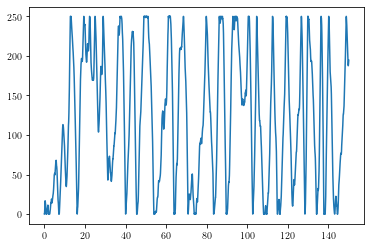

In [183]:
dt = 0.01
T = 150
t = np.arange(0,T,dt)
M = 10 # number of neurons
L = 250 # total length
dL = 0.1
P = 1000
Peff_min = 0.5


params = {
    "tau": 10,
    "q": 100,
    "dt": dt,
    "dL": dL,
    "T": T,
    "P": P,
    "Peff_min": Peff_min,
    "L": L
}

def generate_random_walk_trajectory(params, boundaries=True, round_data=True):
    T = params["T"]
    dt = params["dt"]
    if "L" in params:
        L = params["L"]
    tau = params["tau"]
    q = params["q"]
    dL = params["dL"]
    
    X = np.zeros((int(T/dt),2)) # x and v components
    X[0,0] = 0
    X[0,1] = 0 
    for i in np.arange(1,int(T/dt)):
        x = np.copy(X[i-1,0])
        v = np.copy(X[i-1,1])
        # integrate one timestep using Euler scheme
        X[i,0] = x + v * dt
        X[i,1] = v - 1/tau * v * dt + q * np.random.normal(0,np.sqrt(dt))
        # implement Skohorod boundary conditions
        if boundaries:
            if X[i,0] < 0:
                X[i,0] = 0 # put particle to boundary
                X[i,1] = 0 # set velocity to zero
            elif X[i,0] > L:
                X[i,0] = L # put particle to boundary
                X[i,1] = 0 # set velocity to zero
    if boundaries:
        xaxis = np.arange(0,L,dL) + dL/2 # center of bins
    else:
        xaxis = np.arange(int(X[:,0].min()-2),int(X[:,0].max()+2),dL) + dL/2 # center of bins
    if round_data:
        find_nearest = np.vectorize(lambda x: fn(xaxis, x))
        X[:,0] = find_nearest(X[:,0])
    
    return X, xaxis
        

X, xaxis = generate_random_walk_trajectory(params, boundaries=True, round_data=False)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
params["xaxis"] = xaxis

plt.plot(t,X[:,0])
plt.show()

In [3]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f

H = h(X[:,0],f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()

spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
# X[:,0] = np.around(X[:,0],2)
# xaxis = np.around(xaxis,2)

estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train[:,0], xaxis, dt)

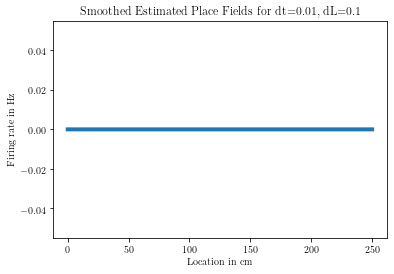

In [4]:
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

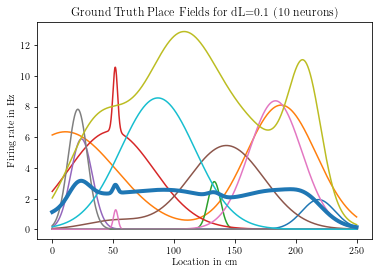

In [5]:
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Particle Filter

In [6]:
def randomwalk_pf(spikes, params):
    T = params["T"]
    dt = params["dt"]
    P = params["P"]
    tau = params["tau"]
    Peff_min = params["Peff_min"]
    L = params["L"]
    xaxis = params["xaxis"]
    place_fields = params["smoothed_place_fields"]
    dL = params["dL"]
    q = params["q"]
    t = int(T/dt)
    
    x = np.zeros((t, 2, P))
    w = np.full((t, P), 1/P)
    
    def boundary(x_t):
        if x_t[0] <= 0:
            x_t[0] = 0
            x_t[1] = 0
        elif x_t[0] >= L:
            x_t[0] = L
            x_t[1] = 0
        return x_t
    
    for i in range(1, t):
        # particle transition
        x[i,0] = x[i-1,0] + x[i-1,1] * dt
        dW = np.random.normal(scale=np.sqrt(dt), size=P)
        x[i,1] = x[i-1,1] - (x[i-1,1] / tau) * dt + q * dW
        x[i] = np.apply_along_axis(boundary, 0, x[i])
        
        # weight update
        w[i] = w[i-1] * np.prod( poisson.pmf(spikes[i],h(x[i,0],place_fields,xaxis,dL).transpose()*dt) , 1)

        w[i] /= np.sum(w[i])
        
        while np.isnan(np.sum(w[i])):
            # all particles have 0 posterior probability, so we need to resample from the uniform
            x[i,0] = np.random.uniform(0, L, P)
            x[i,1] = 0
            w[i] = (1/P) * np.prod( poisson.pmf(spikes[i],h(x[i,0],place_fields,xaxis,dL).transpose()*dt) , 1)
            w[i] /= np.sum(w[i])
        
        if 1 / np.sum(w[i] ** 2) < Peff_min * P:
            x[i], w[i] = resample(x[i], w[i], P)
                   
    return x, w

In [7]:
x_pf, w_pf = randomwalk_pf(spikes, params)

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [ ]:
mu = np.sum(x_pf[:,0,:] * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation[:,0]).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test[:,0]).mean()

In [ ]:
plt.plot(t,X[:,0])
plt.plot(t,mu)
plt.title("Actual Trajectory and Particle Filter Reconstruction (Random Walk) for dt={}, dL={}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(dt, dL, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

In [ ]:
# produces weighted histogram images
def histImage(x, bins, rang, w=0):
    image = np.zeros((x.shape[0],bins))
    
    if np.isscalar(w):
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,density=True)[0]
    else:
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,weights=w[i,:],density=True)[0]
        
    return image

In [ ]:
T_stop = 30

plotrange = [0,T_stop,0,L]

fig, (ax2) = plt.subplots(1,1,figsize=(10,6))



hist = np.transpose(histImage(x_pf[:,0,:],15,(-10,L),w=w_pf)) * 100
ax2.imshow(np.flipud(hist[:,:int(T_stop/dt)]), cmap='Oranges', interpolation='nearest', extent=[0,T_stop,0,L],aspect='auto',vmax=0.7)
ax2.plot(t[:int(T_stop/dt)],X[:int(T_stop/dt),0],color='xkcd:moss')
ax2.plot(t[:int(T_stop/dt)],np.average(x_pf[:,0,:],1,w_pf)[:int(T_stop/dt)], linewidth=1,color = 'xkcd:azure')
ax2.axis(plotrange)
ax2.legend(['hidden state','BPF'],fontsize=16)
ax2.legend([r'$x_t$',r'$\mu_t$ (BPF)'])
plt.title("IRW Ground Truth vs BPF with Weighted Heatmap of BPF Predictions")
plt.ylabel("Location in cm")
plt.xlabel("Time in s")

plt.show()

### Parameter search for IBM Model

In [211]:
def fit_random_walk_model(X, dt, use_velocity=False, q=None, tau=None):
    if len(X.shape) > 1:
        pos = X[:,0]
    else:
        pos = X
    if use_velocity:
        base_velocity = X[:,1]
    else:
        base_velocity = np.diff(pos) / dt
            
    mu_hat = 1 - (np.sum(base_velocity[1:] * base_velocity[:-1]) / np.sum(base_velocity[:-1] ** 2))
    mu_hat /= dt
    
    if tau:
        mu_hat = 1.0 / tau
    
    q_hat = np.sum((base_velocity[1:] - base_velocity[:-1] + base_velocity[:-1] * mu_hat * dt) ** 2)
    q_hat /= dt * (X.shape[0] - 1)
    q_hat = np.sqrt(q_hat)
    
    if q:
        q_hat = q
    
    tau_hat = 1.0 / mu_hat
    
    return q_hat, tau_hat

def using_clump(a):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

def fit_random_walk_no_boundaries(X, dt):
    pos = np.copy(X_train[:,0])
    pos[pos<5] = nan
    pos[pos>245] = nan
    split_pos = using_clump(pos)
    best_params = map(lambda x: fit_random_walk_model(x, dt), split_pos)
    best_params = np.array(list(best_params))
    split_lens = [len(x) for x in split_pos]
    q_hat = np.average(best_params[:,0], weights=split_lens)
    tau_hat = np.average(best_params[:,1], weights=split_lens)
    return q_hat, tau_hat

def get_likelihood(X, dt, q, tau):
    sd = q * np.sqrt(dt)
    l = 0
    v = X[:,1]
    summand = np.diff(v) + (dt * (1/tau) * v[:-1])
    summand = summand ** 2
    l += np.sum(summand)
    l /= - (2 * (sd ** 2))
    log_term = (1 - X.shape[0]) * np.log(sd)
    l += log_term
    return l

def fit_random_walk_model_empirically(X, dt, samples=100, tau_range=(0, 10), q_range=(0, 100), use_velocity=True):
    taus = np.sort(np.random.uniform(tau_range[0], tau_range[1], samples))
    qs = np.sort(np.random.uniform(q_range[0], q_range[1], samples))
    likelihoods = {}
    v = np.diff(X[:,0]) / dt
    if use_velocity:
        v = X[:,1]
    base_diffs = np.diff(v)
    
    best_tau = 0
    best_q = 0
    max_likelihood = float("-inf")
    for tau, q in product(taus, qs):
        likelihood = get_likelihood(X, dt, q, tau)
        likelihoods[tau, q] = likelihood
        if likelihood > max_likelihood:
            max_likelihood = likelihood
            best_tau = tau
            best_q = q
    likelihoods = pd.Series(likelihoods).reset_index()
    likelihoods.columns = ["tau","q","likelihood"]
    return best_q, best_tau, likelihoods

def fit_q_empirically(X, dt, tau, samples=1000, q_range=(0, 200), use_velocity=True):
    qs = np.sort(np.random.uniform(q_range[0], q_range[1], samples))
    likelihoods = []
    v = np.diff(X[:,0]) / dt
    if use_velocity:
        v = X[:,1]
    base_diffs = np.diff(v)
    
    best_q = 0
    max_likelihood = float("-inf")
    for q in qs:
        # p(X|sigma)           
        likelihood = get_likelihood(X, dt, q, tau)
        likelihoods.append(likelihood)
        if likelihood > max_likelihood:
            max_likelihood = likelihood
            best_q = q
            
    likelihoods = pd.Series(likelihoods, index=qs).reset_index()
    likelihoods.columns = ["q","likelihood"]
    return best_q, likelihoods

def fit_tau_empirically(X, dt, q, samples=1000, tau_range=(0, 20), use_velocity=True):
    taus = np.sort(np.random.uniform(tau_range[0], tau_range[1], samples))
    likelihoods = []
    v = np.diff(X[:,0]) / dt
    if use_velocity:
        v = X[:,1]
    base_diffs = np.diff(v)
    
    best_tau = 0
    max_likelihood = float("-inf")
    for tau in taus:
        likelihood = get_likelihood(X, dt, q, tau)
        likelihoods.append(likelihood)
        if likelihood > max_likelihood:
            max_likelihood = likelihood
            best_tau = tau
            
    likelihoods = pd.Series(likelihoods, index=taus).reset_index()
    likelihoods.columns = ["tau","likelihood"]
    return best_tau, likelihoods

## Testing IBM on IBM Data

In [231]:
true_tau = np.random.uniform(0, 1)
true_q = np.random.uniform(0, 5)

params["tau"] = true_tau
params["q"] = true_q
T = 1500
params["T"] = T
t = np.arange(0,T,dt)

X, xaxis = generate_random_walk_trajectory(params, boundaries=False, round_data=False)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])

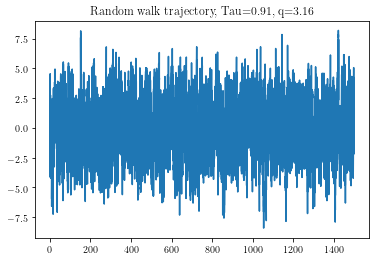

In [232]:
plt.title("Random walk trajectory, Tau={:.2f}, q={:.2f}".format(true_tau, true_q))
plt.plot(t,X[:,1])

In [233]:
_, _, likelihoods = fit_random_walk_model_empirically(X_train, dt, samples=1000)

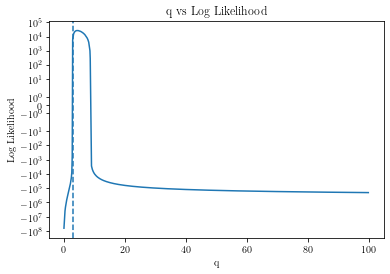

In [234]:
q_likelihoods = likelihoods.groupby('q').mean().sort_values('q')
plt.plot(q_likelihoods.index, q_likelihoods.likelihood)
plt.yscale('symlog')
plt.title("q vs Log Likelihood")
plt.xlabel("q")
plt.ylabel("Log Likelihood")
plt.axvline(x=true_q, ls='--')
plt.show()

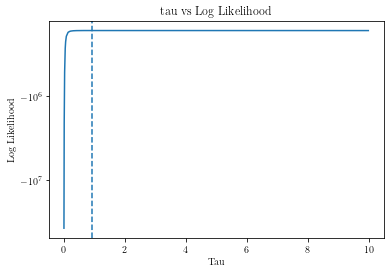

In [235]:
tau_likelihoods = likelihoods.groupby('tau').mean().sort_values('tau')
plt.plot(tau_likelihoods.index, tau_likelihoods.likelihood)
plt.yscale('symlog')
plt.title("tau vs Log Likelihood")
plt.xlabel("Tau")
plt.ylabel("Log Likelihood")
plt.axvline(x=true_tau, ls='--')
plt.show()

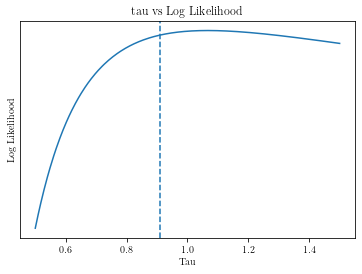

In [236]:
plt.plot(tau_likelihood_true_q.tau, tau_likelihood_true_q.likelihood)
plt.yscale('symlog')
plt.title("tau vs Log Likelihood")
plt.xlabel("Tau")
plt.ylabel("Log Likelihood")
plt.axvline(x=true_tau, ls='--')
plt.show()

In [238]:
q_hat, tau_hat = fit_random_walk_model(X, dt, use_velocity=False) 
params["q"] = q_hat
params["tau"] = tau_hat
print(q_hat, tau_hat)

3.1569571527407487 0.9067164592806999


## Generating Place Fields + Running PF

In [ ]:
# f = generatePlaceFields1D(M,xaxis,L)
# params["f"] = f

# H = h(X[:,0],f,xaxis,dL)
# dN = np.random.poisson(H * dt)
# spikes = dN.transpose()

# spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
# estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train, xaxis, dt)
# params["estimated_place_fields"] = estimated_place_fields
# params["smoothed_place_fields"] = smoothed_place_fields

In [ ]:
# x_pf, w_pf = randomwalk_pf(spikes, params)

In [ ]:
# mu = np.sum(x_pf[:,0,:] * w_pf, 1)
# mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation[:,0]).mean()
# mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test[:,0]).mean()

In [ ]:
# plt.plot(t,X[:,0])
# plt.plot(t,mu)
# plt.title("IBM Trajectory and IBM PF Reconstruction for q={:.2f}, tau={:.2f}, estimated q={:.2f}, tau={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(true_q, true_tau, q_hat, tau_hat, mean_validation_err, mean_test_err))
# plt.legend(['Ground Truth', 'PF'])
# plt.ylabel("Location in cm") 
# plt.xlabel("Time in s")
# plt.axvline(len(X_train) * dt, ls='--')
# plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
# plt.figtext(0.59,0.8,"Validation")
# plt.figtext(0.75,0.8,"Test")
# plt.show()

In [ ]:
# Generate a process without boundary conditions, fixed tau and see if q can be estimated, long process time
# This should be fine, if so add in boundary conditions
# First try boundary conditions with small q, then a large q, see how it affects the fitting
# For prior with boundary conditions, just use the ground truth at that point and fit to it


# To make this, think carefully about what you want to put where
# Think about what figures you want
# Plots:
# Fitted place fields
# 

In [181]:
np.diff(X[:,0])

array([0. , 0. , 0. , ..., 0. , 0. , 0.1])

In [209]:
X[1:,1] - X[:-1,1]

array([-0.07926462,  0.2161304 ,  0.04839902, ...,  0.04439198,
       -0.04038429,  0.0759604 ])

In [210]:
np.diff(X[:,1])

array([-0.07926462,  0.2161304 ,  0.04839902, ...,  0.04439198,
       -0.04038429,  0.0759604 ])